In [107]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [108]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding = OpenAIEmbeddings()
)

In [109]:
retriever = vectorstore.as_retriever()

In [110]:
### Query Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

class RouteQuery(BaseModel):
    """Route a user query to the most relevant data source"""
    datasource: Literal["vectorstore","web_search"] = Field(
        description = "Given a user question choose to route it to web search or a vectorstore."
    )

llm = ChatOpenAI(model="gpt-4o-mini")
structured_llm_router = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}")
    ]
)

question_router = route_prompt | structured_llm_router

print(question_router.invoke({"question":"what are the types of agent memory"}))

{'datasource': 'vectorstore'}


In [111]:
### Retrieval Grader

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents"""
    binary_score: str = Field(
        description = "Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Retrievd document: \n {document} \n\n User question: \n {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader 

question = "agent memory"

docs = retriever.invoke(question)

doc_txt = docs[0].page_content

print(retrieval_grader.invoke({"question":question,"document":doc_txt}))

{'binary_score': 'yes'}


In [112]:
### Generation

from langchain import hub 
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model_name="gpt-4o-mini",temperature=0)

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

docs = format_docs(docs)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"question":question,"context":docs})
print(generation)

c:\Users\DELL\anaconda3\envs\llmapp\Lib\site-packages\langchain\hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


Agent memory refers to a long-term memory module that records agents' experiences in natural language, allowing them to synthesize higher-level inferences over time. This memory system helps agents behave based on past experiences and interact with other agents effectively. It also distinguishes between recent and important memories to inform the agent's behavior.


In [113]:
### Hallucination Grader

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer"""
    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'No' ")

llm = ChatOpenAI(model="gpt-4o-mini")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","set of facts : \n\n {documents} \n\n LLM Generation: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents":docs,"generation":generation})

{'binary_score': 'yes'}

In [114]:
### Answer Grader 

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question"""
    binary_score:str = Field(
        description = "Answer addresses the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini")
structured_answer_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","User question: \n\n {question} \n\n generation:\n\n {generation}")
    ]
)

answer_grader = answer_prompt | structured_answer_grader

answer_grader.invoke({"question":question,"generation":generation})

{'binary_score': 'yes'}

In [115]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the key concepts and applications of agent memory in artificial intelligence?'

In [116]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)



In [117]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [121]:
from langchain.schema import Document

def retrieve(state:GraphState)->GraphState:
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print(state)
    question = state["question"]

    documents = retriever.invoke(question)
    
    return {"question":question,"documents":documents}

def generate(state:GraphState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context":documents,"question":question})
    return {"question":question,"generation":generation}

def grade_documents(state:GraphState):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    print("---")
    print(state)
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []

    for d in documents:
        score = retrieval_grader.invoke(
            {"question":question,"document":d.page_content}
        )
        grade = score["binary_score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"question":question,"documents":filtered_docs}

def transform_query(state:GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question":question})
    return {"documents":documents,"question":better_question}

def web_search(state:GraphState):
    """
    Web search based on the re-phrased question.

    Args:
    state (dict): The current graph state

    Returns:
    state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]

    docs = web_search_tool.invoke(question)
    
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents":web_results,"question":question}

def route_question(state:GraphState):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question":question})
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"



def decide_to_generate(state:GraphState):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_docs = state["documents"]

    if not filtered_docs:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_vs_documents_and_question(state:GraphState):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """   
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents":documents,"generation":generation}
    )
    grade = score["binary_score"]

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question":question,"generation":generation})
        grade = score["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---") 
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


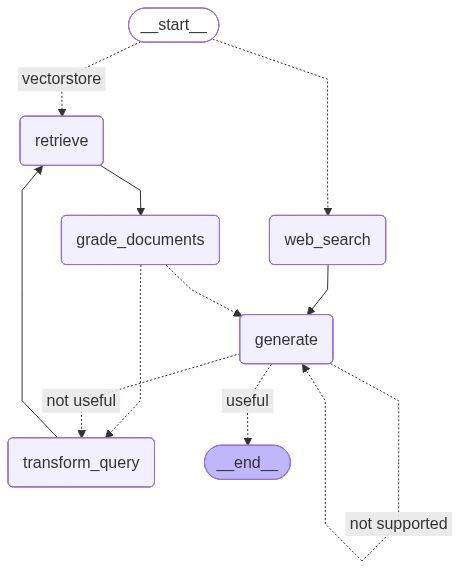

In [122]:
from langgraph.graph import END,StateGraph,START
from IPython.display import display,Image
workflow = StateGraph(GraphState)

workflow.add_node("web_search",web_search)
workflow.add_node("retrieve",retrieve)
workflow.add_node("grade_documents",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("transform_query",transform_query)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore":"retrieve",
        "web_search":"web_search"
    }
)
workflow.add_edge("web_search","generate")
workflow.add_edge("retrieve","grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    }
)
workflow.add_edge("transform_query","retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_vs_documents_and_question,
    {
        "not supported":"generate",
        "useful":END,
        "not useful":"transform_query"
    }
)

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [124]:
inputs = {"question":"Any idea about Gorantla sai krishna working in Tredence and SRM University ?"}

for output in app.stream(inputs):
    print(output)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
{'web_search': {'question': 'Any idea about Gorantla sai krishna working in Tredence and SRM University ?', 'documents': Document(page_content="Sai Krishna Gorantla has attended srm university\n\nWhat companies has Sai Krishna Gorantla worked with?\n\nSai Krishna Gorantla has worked with Tredence Inc.\n\nWhat are some of Sai Krishna Gorantla's skills?\n\nSai Krishna Gorantla has skills in Python (Programming Language), GenAI, Artificial Intelligence, Computer Science, Buying and merchandizing, SQL and more.\n\nI don’t want my profile to be displayed. How can I request deletion?\n\nYou can request deletion here - Delete my profile [...] Our storyPricingBook demo\n\nFor Candidates\n\nFor Companies\n\nEmployer LoginFor Candidates\n\n## Say no to manually filling long application forms\n\n### Visit any careers page and a lightning button will pop up on any compatible page. Use ChatGPT to auto-fill\n\nUse AI to auto fi